# Exercise 2
### Kevin Heibel, Max Heise
### Tutor: Jeremias Traub

## 1 Data Preparation

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

digits = load_digits ()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [2]:
restricted_data = data[(target == 1) | (target == 7)]
restricted_target = target[(target == 1) | (target == 7)]

X_train , X_test , Y_train , Y_test =\
    model_selection.train_test_split( restricted_data, restricted_target,
          test_size = 0.4, random_state = 0)


### 1.1 Dimension Reduction

In [3]:
'''
Just some experiments to find some suitable pixels.
'''

def find_best_pixel(x):
    pixel_mean = np.array([x[:,i].mean() for i in range(64)])
    pixel_std = np.array([x[:,i].std() for i in range(64)])
    return pixel_mean, pixel_std

number1_mean, number1_std = find_best_pixel(X_train[(Y_train == 1)])
number7_mean, number7_std = find_best_pixel(X_train[(Y_train == 7)])

dif = np.absolute(number1_mean - number7_mean)

ind = np.argpartition(dif, -7)[-7:]
array = dif[ind]
print(ind)
print(array)
print(number1_std[ind])
print(number7_std[ind])

[20 27 53 52 61 60 19]
[ 6.54786258  7.82533438  8.15237346  8.68161553  9.13558878 11.27170207
 11.78232363]
[3.68047622 3.6242841  6.48050611 3.03283636 6.07899613 3.19415985
 2.43449444]
[5.71992479 5.31707111 0.51298324 4.60860265 0.10313616 2.80803729
 3.69091406]


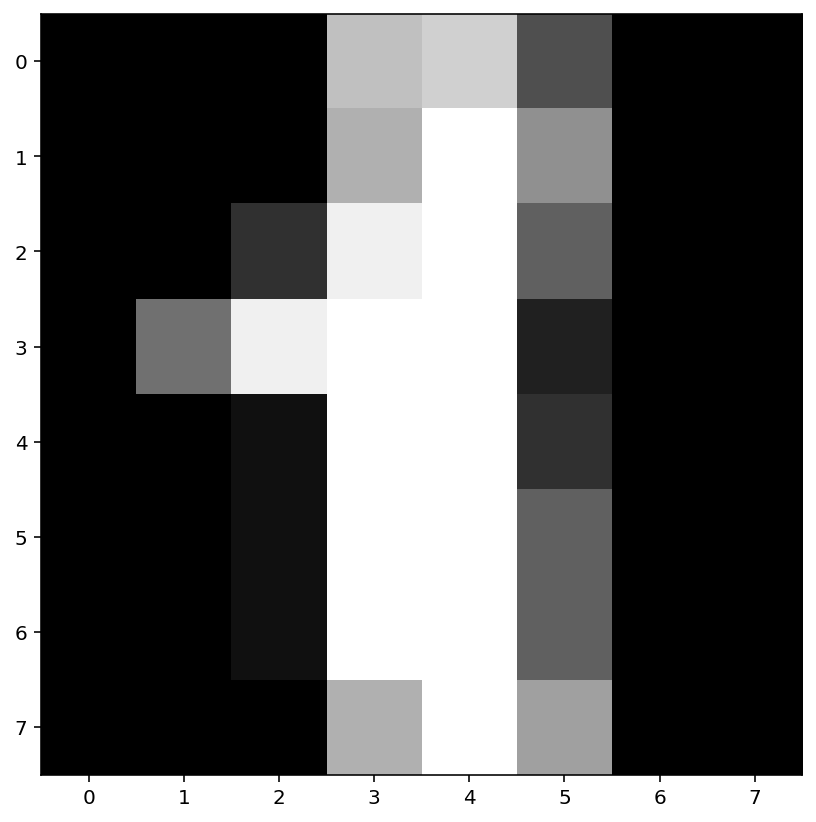

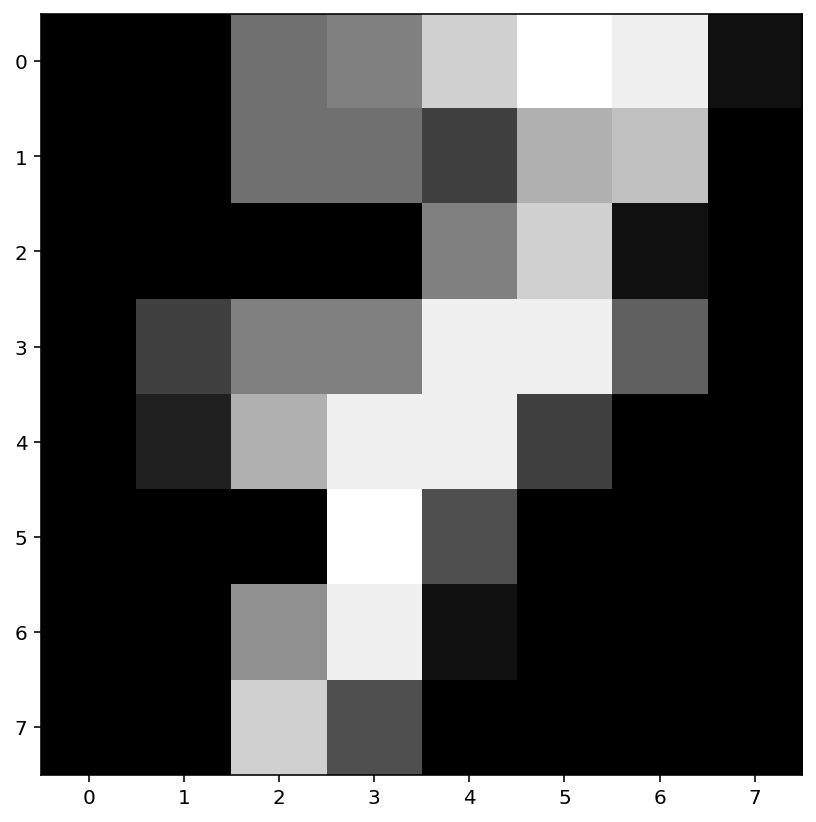

In [4]:
'''
For visual inspection.
'''
for img in images[(target == 1) | (target == 7)][:2]:
    plt.figure()
    plt.gray()
    plt.imshow(img , interpolation ="nearest")
    plt.show()

In [5]:
'''
function to reduce 64 pixel values to two-dimensional feature
How?: Choose four pixels with low std for both numbers and a high mean-difference for the
same pixel between the numbers. For both features take the mean of two of those pixels.
input: N × 64 matrix, N instances with 64 pixel values
output N × 2 matrix, N instances with 2 features
'''

def reduce_dim(x):
    feature1 = (x[:,19] + x[:,52]) / 2
    feature2 = (x[:,60] + x[:,27]) / 2
    return feature1, feature2

<div style="color: green; font-weight: bold">
Nice approach :)
</div>


### 1.2 Scatterplot

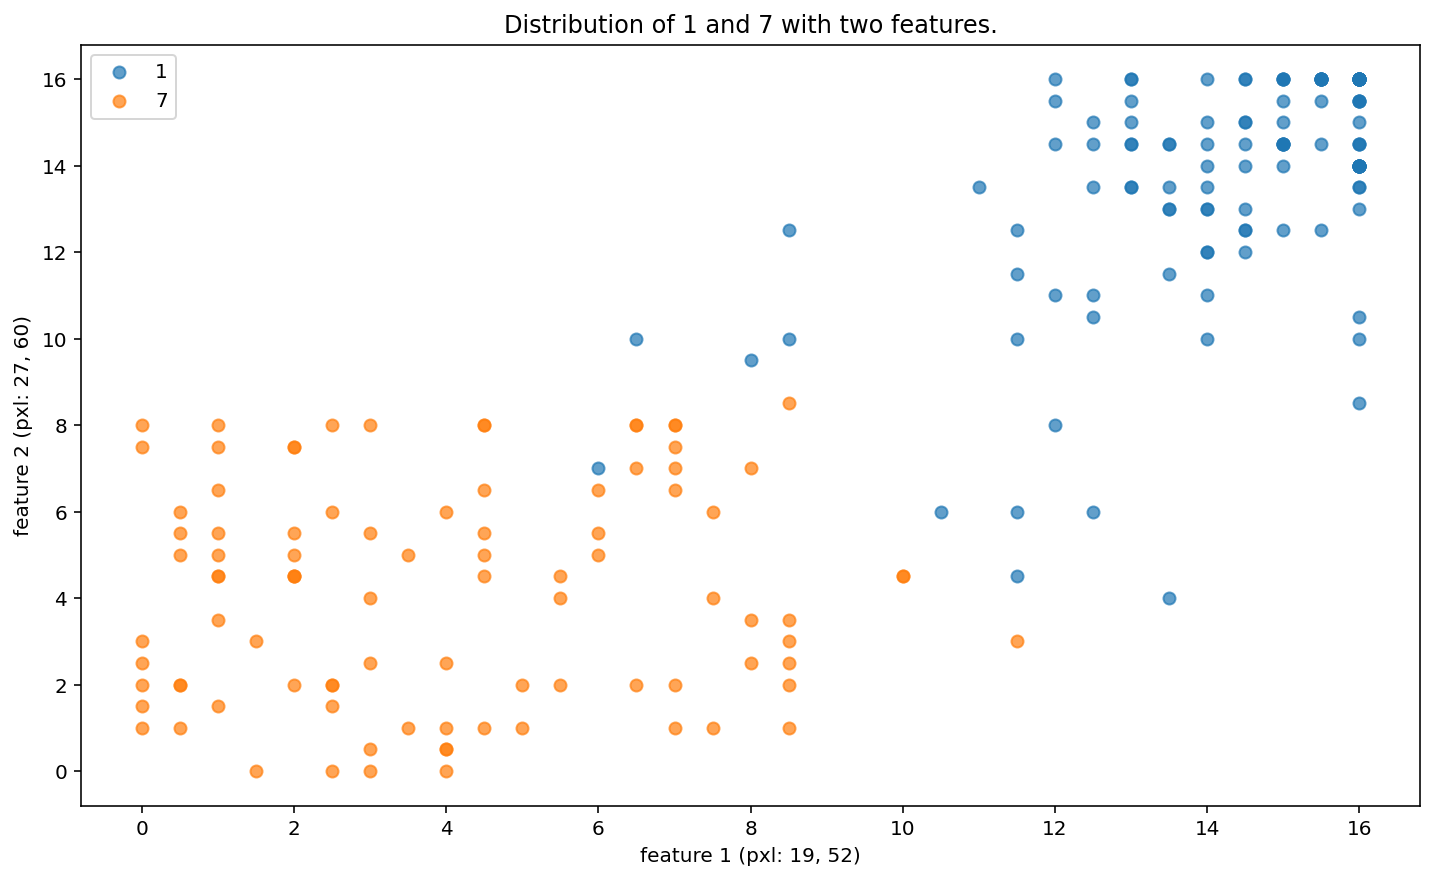

In [6]:
feature_1_1,feature_2_1 = reduce_dim(X_train[(Y_train == 1)])
feature_1_7,feature_2_7 = reduce_dim(X_train[(Y_train == 7)])

plt.scatter(feature_1_1,feature_2_1,label="1",alpha=0.7)
plt.scatter(feature_1_7,feature_2_7,label="7",alpha=0.7)
plt.xlabel("feature 1 (pxl: 19, 52)")
plt.ylabel("feature 2 (pxl: 27, 60)")
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = (10,10)
t = plt.title("Distribution of 1 and 7 with two features.")

<div style="color: green; font-weight: bold">
This looks correct
</div>


## 2 Nearest Mean

### 2.1 Implement the nearest mean classifier

In [7]:
def nearest_mean(training_feature_1, training_feature_2, training_labels, test_feature_1, test_feature_2):
    class1_mean_feature_1 = training_feature_1[(training_labels == 1)].mean()
    class7_mean_feature_1 = training_feature_1[(training_labels == 7)].mean()
    class1_mean_feature_2 = training_feature_2[(training_labels == 1)].mean()
    class7_mean_feature_2 = training_feature_2[(training_labels == 7)].mean()
    
    training = np.array([[class1_mean_feature_1, class1_mean_feature_2], [class7_mean_feature_1, class7_mean_feature_2]])
    test = np.array([test_feature_1, test_feature_2]).T
    
    N = training.shape[0]
    M = test.shape[0]

    training_squared = (training*training).sum(axis=1).reshape((N,1))*np.ones(shape=(1,M))
    test_squared = (test*test).sum(axis=1)*np.ones(shape=(N,1))
    distance_matrix =  np.sqrt(training_squared + test_squared - 2 * training.dot(test.T))
    
    distance_difference = distance_matrix[0] - distance_matrix[1]
    
    predicted_labels = np.array(distance_difference)
    predicted_labels[predicted_labels <= 0] = -1
    predicted_labels[predicted_labels > 0] = -7
    predicted_labels = predicted_labels * -1
    
    return predicted_labels

def calculate_means(training_feature_1, training_feature_2, training_labels):
    class1_mean_feature_1 = training_feature_1[(training_labels == 1)].mean()
    class7_mean_feature_1 = training_feature_1[(training_labels == 7)].mean()
    class1_mean_feature_2 = training_feature_2[(training_labels == 1)].mean()
    class7_mean_feature_2 = training_feature_2[(training_labels == 7)].mean()
    return class1_mean_feature_1, class1_mean_feature_2 ,class7_mean_feature_1, class7_mean_feature_2

<div style="color: green; font-weight: bold">
The inputs should be maxtrices not a vector for each feature.

Using np.square would be a lot easier to read.

If you would just use predicted_labels[distance_difference <= 0] = 1 you could remove the confusing minuses.
</div>

In [2]:
training_feature_1, training_feature_2 = reduce_dim(X_train)
test_feature_1, test_feature_2 = reduce_dim(X_test)

predicted_labels = nearest_mean(training_feature_1, training_feature_2, Y_train, test_feature_1, test_feature_2)
print(predicted_labels)

NameError: name 'reduce_dim' is not defined


### 2.2 Visualize the decision regions

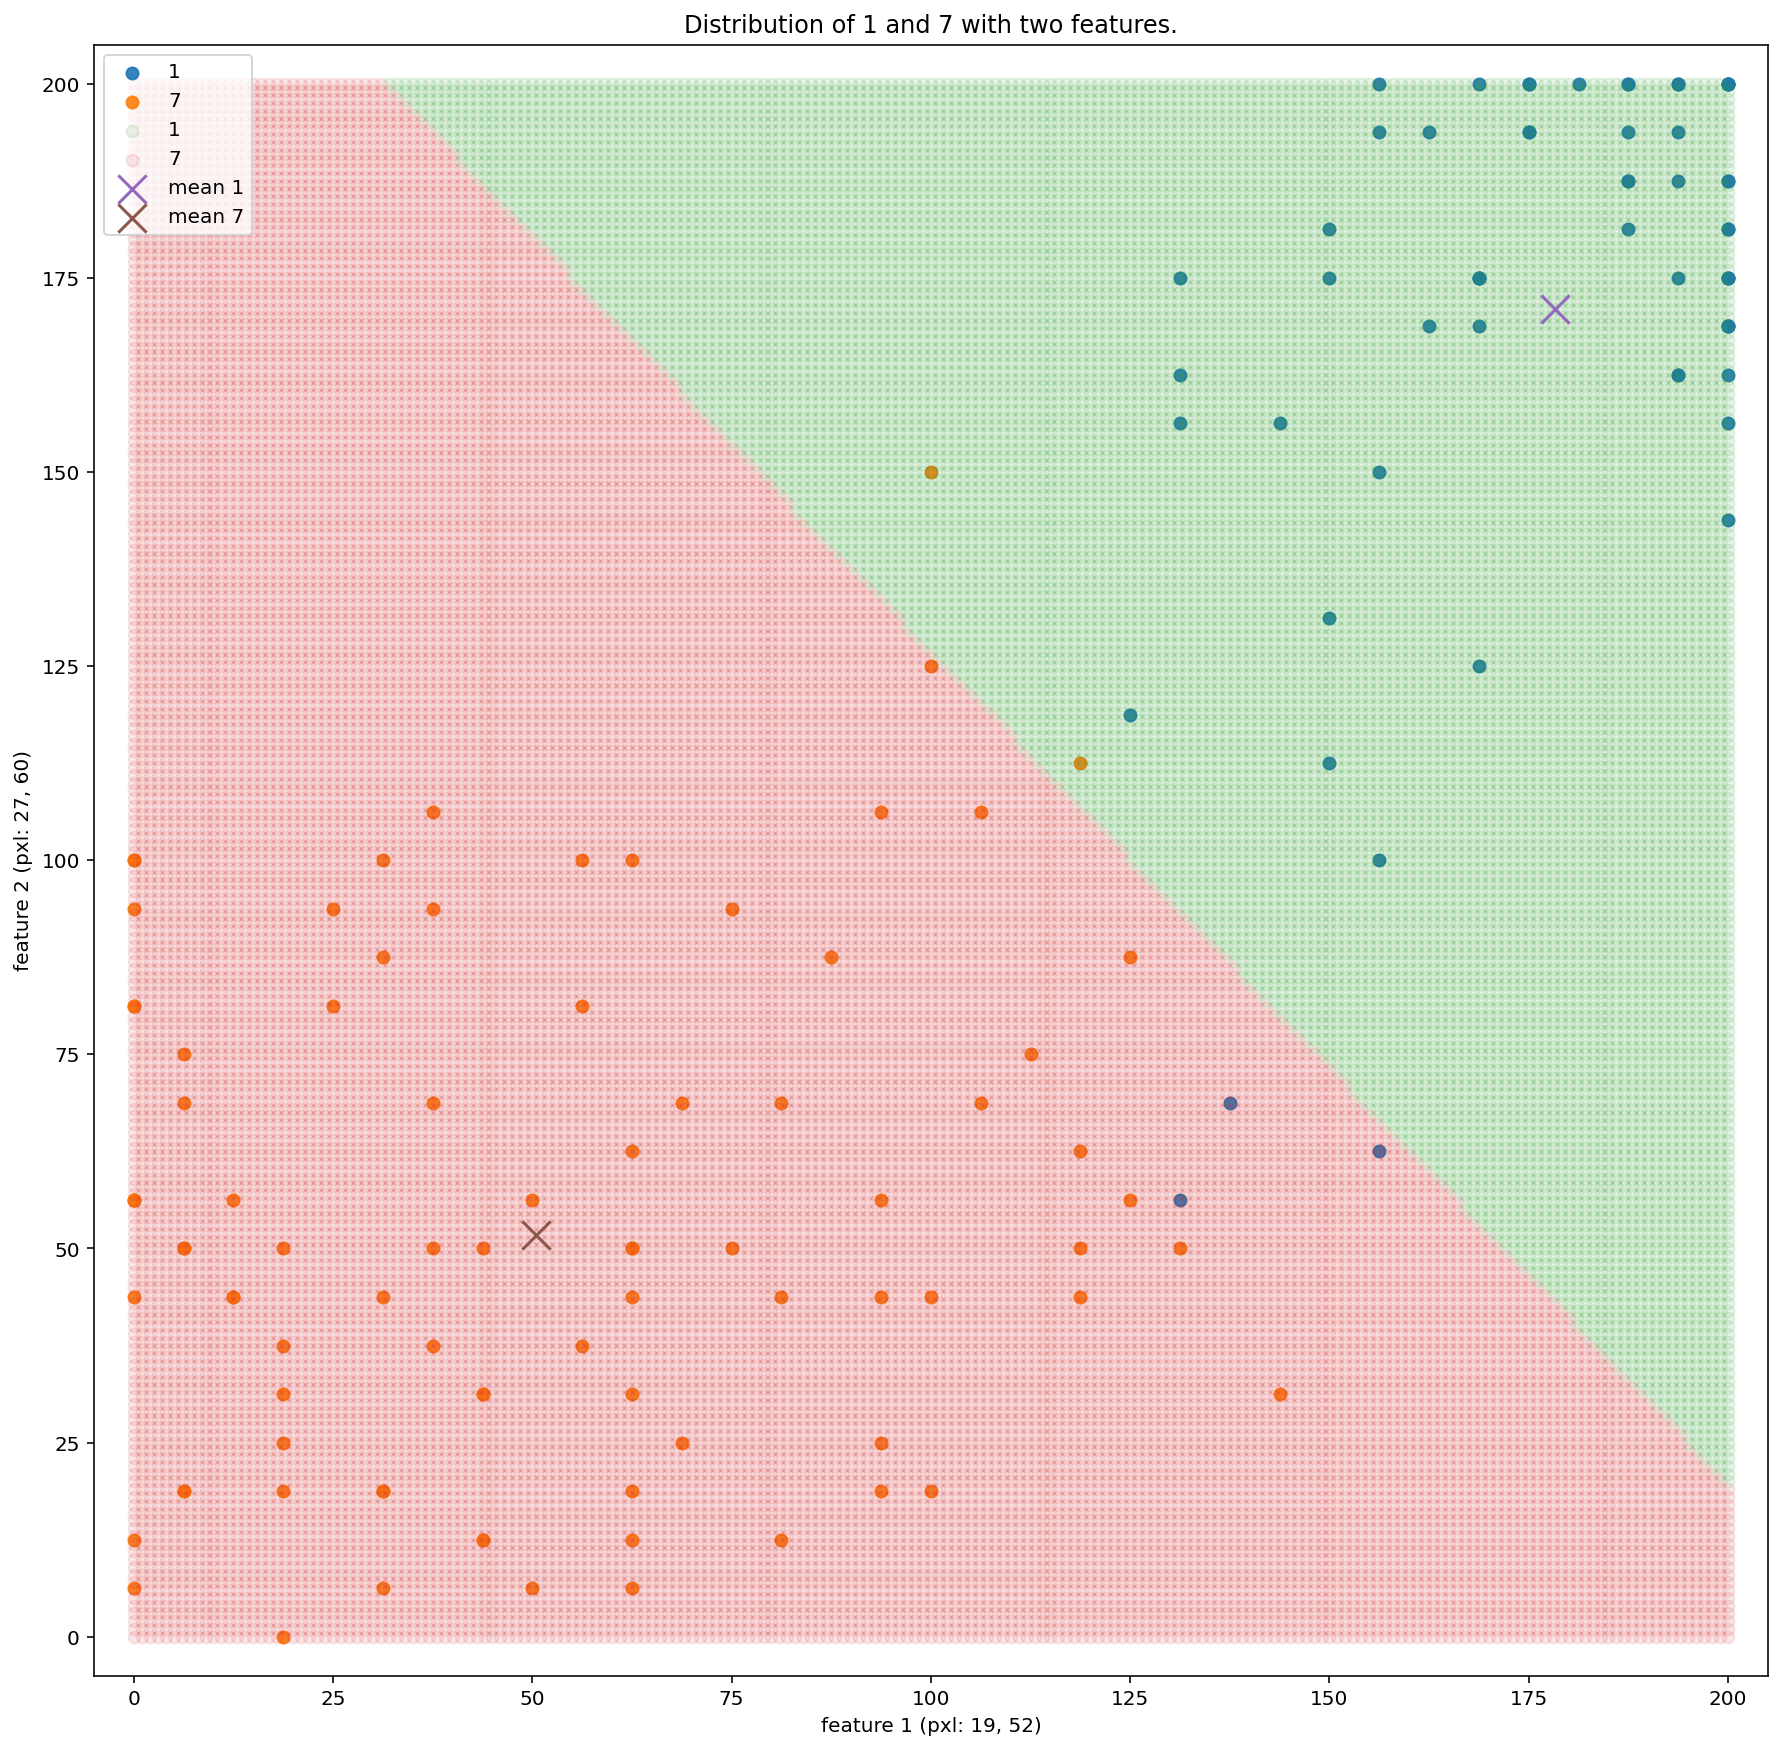

In [20]:
all_pixels_1 = np.array([np.arange(201) for i in range(201)]).flatten() / 200 *16
all_pixels_2 = np.array([np.ones(201) * i for i in range(201)]).flatten() / 200 *16

all_pixels = nearest_mean(training_feature_1, training_feature_2, Y_train, all_pixels_1, all_pixels_2)
all_pixels_1_class1 = all_pixels_1[all_pixels == 1] * 200 / 16
all_pixels_2_class1 = all_pixels_2[all_pixels == 1] * 200 / 16
all_pixels_1_class7 = all_pixels_1[all_pixels == 7] * 200 / 16
all_pixels_2_class7 = all_pixels_2[all_pixels == 7] * 200 / 16

class1_mean_1,class1_mean_2,class7_mean_1,class7_mean_2 = calculate_means(training_feature_1, training_feature_2, Y_train)

test_feature_1_class_1 = test_feature_1[Y_test == 1]
test_feature_2_class_1 = test_feature_2[Y_test == 1]
test_feature_1_class_7 = test_feature_1[Y_test == 7]
test_feature_2_class_7 = test_feature_2[Y_test == 7]

plt_feature_1_1 = test_feature_1_class_1 * 200 / 16
plt_feature_2_1 = test_feature_2_class_1 * 200 / 16
plt_feature_1_7 = test_feature_1_class_7 * 200 / 16
plt_feature_2_7 = test_feature_2_class_7 * 200 / 16

plt.scatter(plt_feature_1_1,plt_feature_2_1,label="1",alpha=0.9)
plt.scatter(plt_feature_1_7,plt_feature_2_7,label="7",alpha=0.9)
plt.scatter(all_pixels_1_class1,all_pixels_2_class1,label="1",alpha=0.1)
plt.scatter(all_pixels_1_class7,all_pixels_2_class7,label="7",alpha=0.1)
plt.scatter(class1_mean_1 * 200 / 16,class1_mean_2 * 200 / 16,label="mean 1",alpha=1, marker="x", s=200)
plt.scatter(class7_mean_1 * 200 / 16,class7_mean_2 * 200 / 16,label="mean 7",alpha=1, marker="x", s=200)
plt.xlim(-5, 205)
plt.ylim(-5, 205)
plt.xlabel("feature 1 (pxl: 19, 52)")
plt.ylabel("feature 2 (pxl: 27, 60)")
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = (15,15)
t = plt.title("Distribution of 1 and 7 with two features.")

<div style="color: green; font-weight: bold">
Plot seems correct and looks nice.
</div>


## 3 QDA

### 3.1 Implement QDA Training

In [10]:
'''
input: N × D matrix, training_features with N instances and D features per instance
       N training_labels
       
output: 2 × D matrix, mu whose rows are the two class means
        2 × D × D matrix, covmat containing the two covariance matrices
        p containing the two priors
'''

def fit_qda(training_features, training_labels):
    D = training_features.shape[1]
    N = training_labels.shape[0]
    training_features_1 = training_features[training_labels == 1]
    training_features_7 = training_features[training_labels == 7]
    count_1 = training_labels[training_labels == 1].shape[0]
    count_7 = training_labels[training_labels == 7].shape[0]
    
    p = np.array([count_1 / N, count_7 / N])
    
    mu = np.array([[np.mean(training_features_1[:,i]) for i in range(D)],\
                   [np.mean(training_features_7[:,i]) for i in range(D)]])
    
    sigma1 = np.zeros((D,D))
    for i in range(training_features_1.shape[0]):
        diviation = (training_features_1[i] - mu[0]).reshape(1, training_features_1.shape[1])
        diviationT = diviation.reshape(training_features_1.shape[1], 1)
        matrix = diviationT.dot(diviation)
        sigma1 = sigma1 + matrix
    sigma1 = sigma1 / training_features_1.shape[0]
    
    sigma2 = np.zeros((D,D))
    for i in range(training_features_7.shape[0]):
        diviation = (training_features_7[i] - mu[1]).reshape(1, training_features_7.shape[1])
        diviationT = diviation.reshape(training_features_7.shape[1], 1)
        matrix = diviationT.dot(diviation)
        sigma2 = sigma2 + matrix
    sigma2 = sigma2 / training_features_7.shape[0]
    
    sigma = np.array([sigma1, sigma2])
    
    return mu, sigma, p

<div style="color: green; font-weight: bold">
The computation of the standard devition can be vectorized. 
</div>

### 3.2 Implement QDA Prediction

In [11]:
def predict_qda(mu, covmat, p, test_features):
    D = p.shape[0]
    M = test_features.shape[0]
    
    Y = np.zeros(M)
    for i in range(M):
        Ys = np.zeros(2)
        for k in range(D):
            f = 1/2*((test_features[i] - mu[k]).reshape(1, D)).dot(np.linalg.inv(covmat[k])).dot((test_features[i] - mu[k]).reshape(D, 1)) + b_k(covmat[k], p[k])
            Ys[k] = f
        Y[i] = np.argmin(Ys)
    return Y * 6 +1

def b_k(sigma, p):
    return 0.5*np.log(np.linalg.det(sigma*np.pi*2))-np.log(p)

def error_test(Y_True, Y_Estimate):
    y_is_false = 0
    for i in range(Y_True.shape[0]):
        if (Y_True[i] != Y_Estimate[i]):
            y_is_false += 1
    return y_is_false / Y_True.shape[0]

def qda(training_features, training_labels, test_features):
    mu, covmat, p = fit_qda(training_features, training_labels)
    predicted_labels = predict_qda(mu, covmat, p, test_features)
    return predicted_labels

<div style="color: green; font-weight: bold">
Implementation of predict_qda probably could be vectorized (but we also did not managage to do it). It seems correct.
</div>

In [12]:
training_features = np.array([training_feature_1, training_feature_2]).T
test_features = np.array([test_feature_1, test_feature_2]).T

mu, covmat, p = fit_qda(training_features, Y_train)

predicted_labels_train = predict_qda(mu, covmat, p, training_features)

predicted_labels_test = predict_qda(mu, covmat, p, test_features)

errorrate_train = error_test(Y_train, predicted_labels_train)
errorrate_test = error_test(Y_test, predicted_labels_test)

print(errorrate_train)
print(errorrate_test)

0.032407407407407406
0.034482758620689655



### 3.3 Visualization

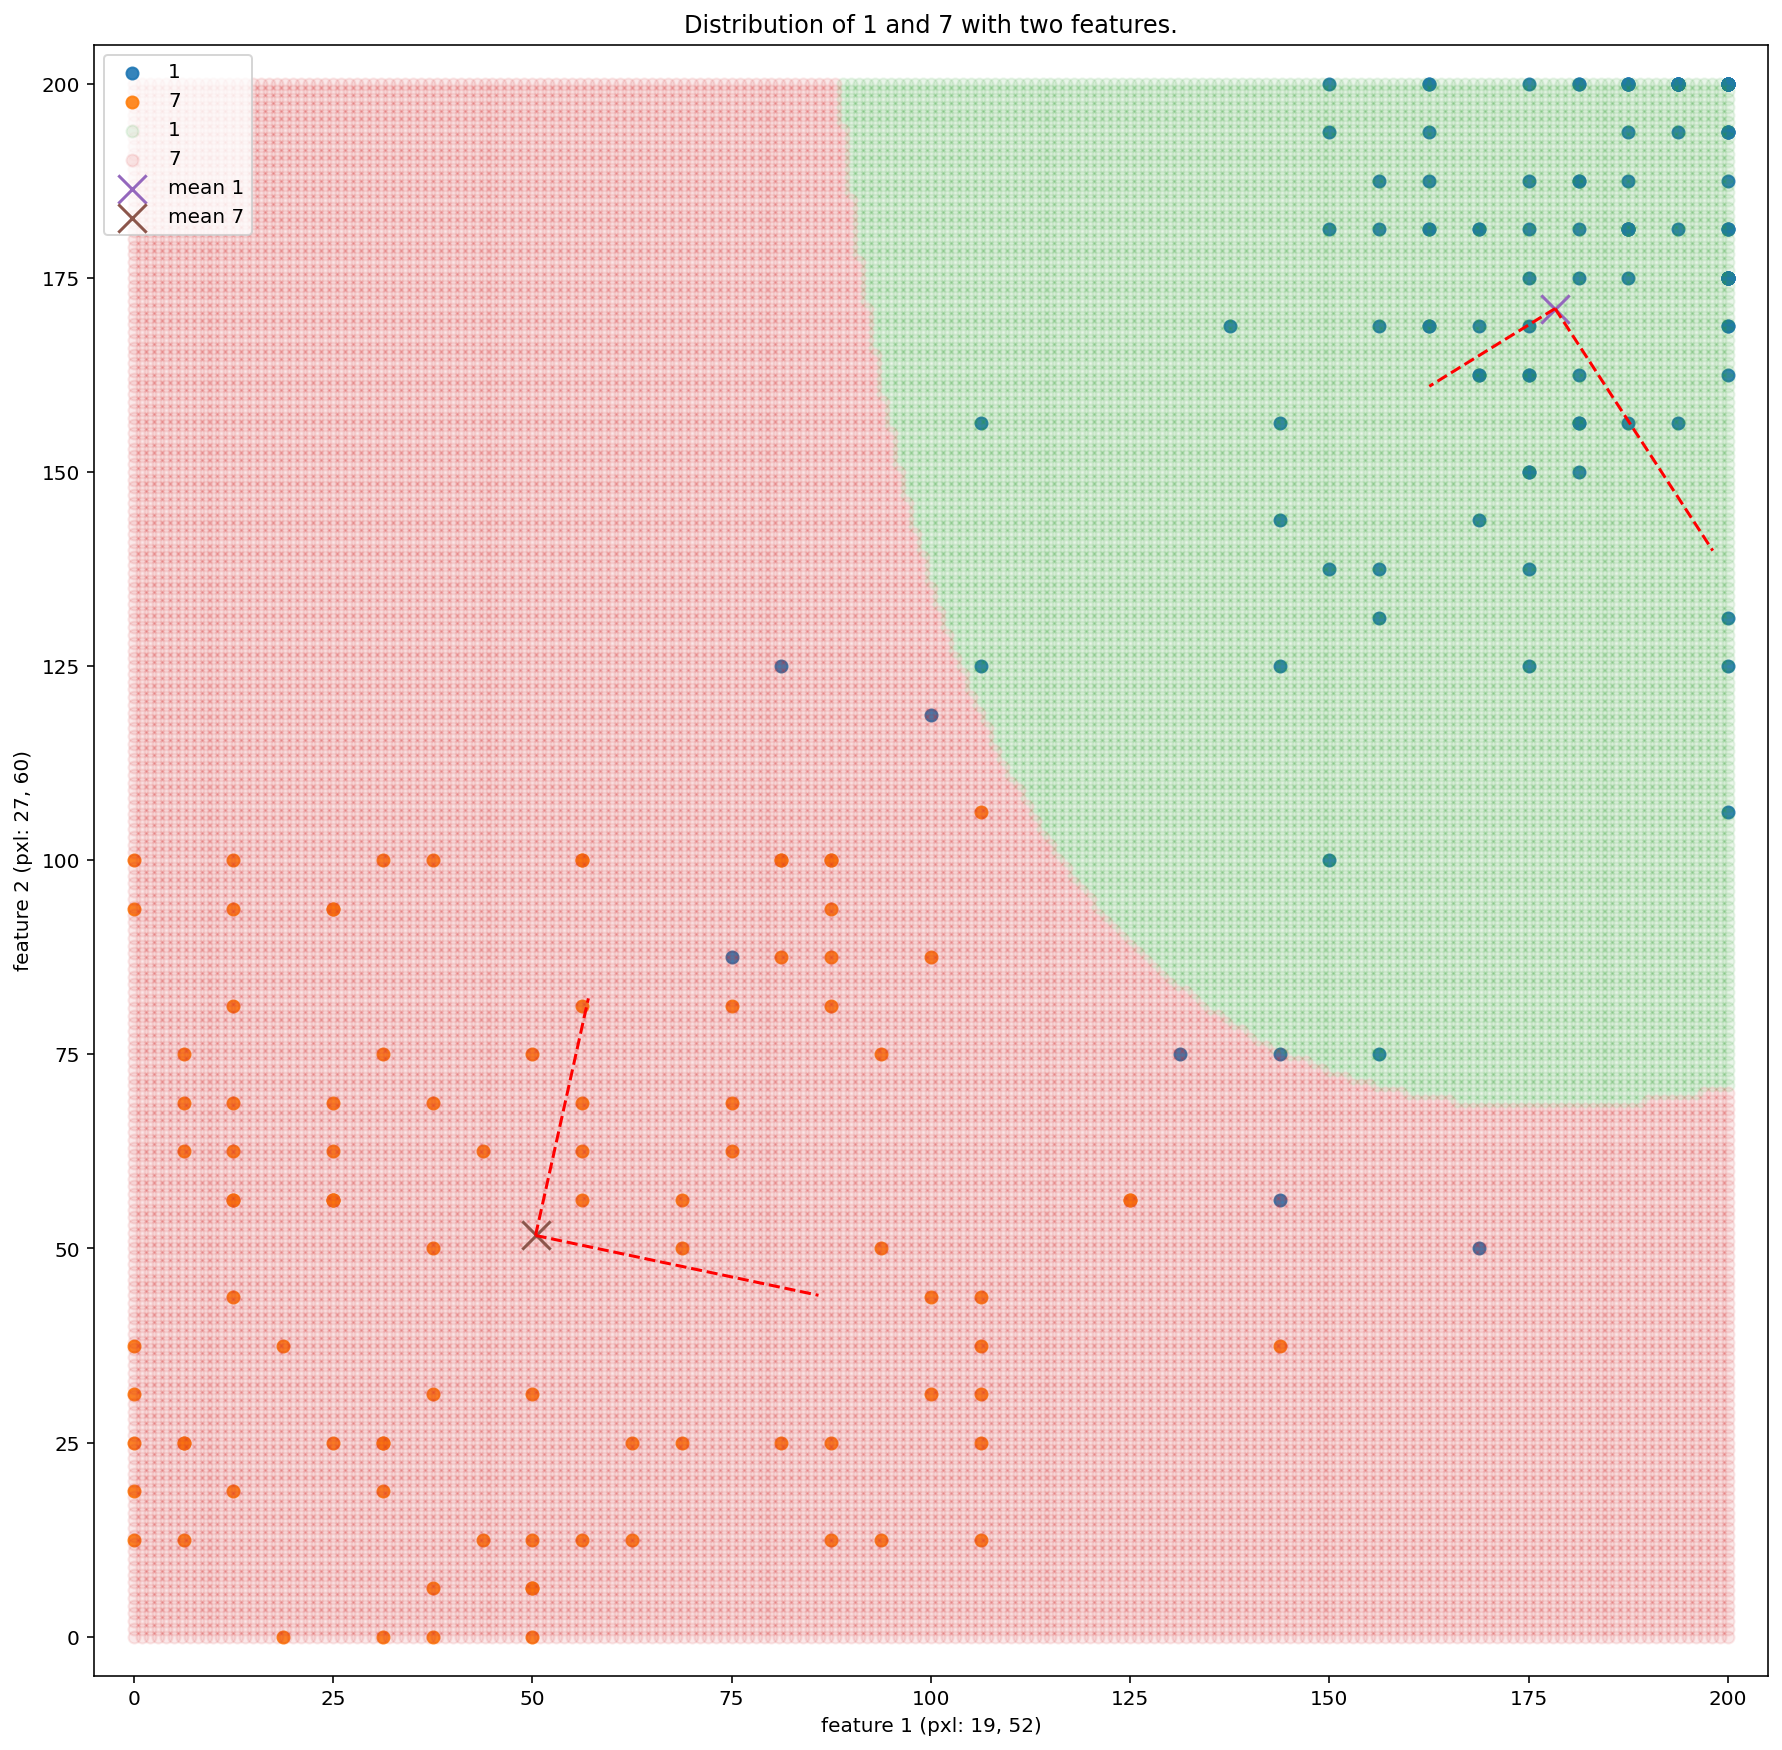

In [13]:
all_pixels_1 = np.array([np.arange(201) for i in range(201)]).flatten() / 200 *16
all_pixels_2 = np.array([np.ones(201) * i for i in range(201)]).flatten() / 200 *16

all_pixels_matrix = np.array([all_pixels_1, all_pixels_2]).T

#Eigenvalue

mu,sigma, p = fit_qda(training_features, Y_train)
w1, v1 = np.linalg.eig(sigma[0])

mu,sigma, p = fit_qda(training_features, Y_train)
w7, v7 = np.linalg.eig(sigma[1])

plt.plot([class1_mean_1 * 200 / 16,(class1_mean_1 * 200 / 16) + (np.sqrt(w1[0])* 200 / 16) * v1[0,0] ],[class1_mean_2 * 200 / 16, (class1_mean_2 * 200 / 16) + (np.sqrt(w1[0])* 200 / 16) * v1[0,1]], "r--")
plt.plot([class1_mean_1 * 200 / 16,(class1_mean_1 * 200 / 16) + (np.sqrt(w1[1])* 200 / 16) * v1[1,0] ],[class1_mean_2 * 200 / 16, (class1_mean_2 * 200 / 16) + (np.sqrt(w1[1])* 200 / 16) * v1[1,1]], "r--")
plt.plot([class7_mean_1 * 200 / 16,(class7_mean_1 * 200 / 16) + (np.sqrt(w7[0])* 200 / 16) * v7[0,0] ],[class7_mean_2 * 200 / 16, (class7_mean_2 * 200 / 16) + (np.sqrt(w7[0])* 200 / 16) * v7[0,1]], "r--")
plt.plot([class7_mean_1 * 200 / 16,(class7_mean_1 * 200 / 16) + (np.sqrt(w7[1])* 200 / 16) * v7[1,0] ],[class7_mean_2 * 200 / 16, (class7_mean_2 * 200 / 16) + (np.sqrt(w7[1])* 200 / 16) * v7[1,1]], "r--")


all_pixels = qda(training_features, Y_train, all_pixels_matrix)
all_pixels_1_class1 = all_pixels_1[all_pixels == 1] * 200 / 16
all_pixels_2_class1 = all_pixels_2[all_pixels == 1] * 200 / 16
all_pixels_1_class7 = all_pixels_1[all_pixels == 7] * 200 / 16
all_pixels_2_class7 = all_pixels_2[all_pixels == 7] * 200 / 16

class1_mean_1,class1_mean_2,class7_mean_1,class7_mean_2 = calculate_means(training_feature_1, training_feature_2, Y_train)

train_feature_1_class_1 = training_feature_1[Y_train == 1]
train_feature_2_class_1 = training_feature_2[Y_train == 1]
train_feature_1_class_7 = training_feature_1[Y_train == 7]
train_feature_2_class_7 = training_feature_2[Y_train == 7]

plt_feature_1_1 = train_feature_1_class_1 * 200 / 16
plt_feature_2_1 = train_feature_2_class_1 * 200 / 16
plt_feature_1_7 = train_feature_1_class_7 * 200 / 16
plt_feature_2_7 = train_feature_2_class_7 * 200 / 16

plt.scatter(plt_feature_1_1,plt_feature_2_1,label="1",alpha=0.9)
plt.scatter(plt_feature_1_7,plt_feature_2_7,label="7",alpha=0.9)
plt.scatter(all_pixels_1_class1,all_pixels_2_class1,label="1",alpha=0.1)
plt.scatter(all_pixels_1_class7,all_pixels_2_class7,label="7",alpha=0.1)
plt.scatter(class1_mean_1 * 200 / 16,class1_mean_2 * 200 / 16,label="mean 1",alpha=1, marker="x", s=200)
plt.scatter(class7_mean_1 * 200 / 16,class7_mean_2 * 200 / 16,label="mean 7",alpha=1, marker="x", s=200)


plt.xlim(-5, 205)
plt.ylim(-5, 205)
plt.xlabel("feature 1 (pxl: 19, 52)")
plt.ylabel("feature 2 (pxl: 27, 60)")
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = (15,15)
t = plt.title("Distribution of 1 and 7 with two features.")

<div style="color: green; font-weight: bold">
Looks pretty good. We don't really understand the purpose of the red lines.
</div>

### 3.4 Performance evaluation QDA

In [14]:
def split_folds(data, target, L):
    perm = np.random.permutation(range(len(target)))
    X_folds = np.array_split(data[perm], L)
    y_folds = np.array_split(target[perm], L)
    return X_folds, y_folds

def cross_validate_qda(data, target, L):

    X_folds, y_folds = split_folds(data, target, L)
    error_rates_own = []

    for n in range(L):
# construct train and test set from folds
        X_train_f = np.concatenate([X_folds[i] for i in range(L) if i != n])
        X_test_f = X_folds[n]
        y_train_f = np.concatenate([y_folds[i] for i in range(L) if i != n])
        y_test_f = y_folds[n]
        
        mu, sigma, p = fit_qda(X_train_f, y_train_f)
        predicted_y = predict_qda(mu, sigma, p, X_test_f)
        error_rates_own.append(error_test(y_test_f, predicted_y))
        
    return np.mean(error_rates_own)

print("test error with 10-fold cross validation:", cross_validate_qda(training_features, Y_train, 10))

test error with 10-fold cross validation: 0.032251082251082246


<div style="color: green; font-weight: bold">
We were allowed to use the functions from scikit-learn (but not required so this is fine). 
</div>


## 4 LDA

### 4.1 Implement LDA Training

In [15]:
'''
input: N × D matrix, training_features with N instances and D features per instance
       N training_labels
       
output: 2 × D matrix, mu whose rows are the two class means
        D × D matrix, covmat sigma_w
        p containing the two priors
'''
def fit_lda(training_features, training_labels):
    D = training_features.shape[1]
    N = training_labels.shape[0]
    training_features_1 = training_features[training_labels == 1]
    training_features_7 = training_features[training_labels == 7]
    count_1 = training_labels[training_labels == 1].shape[0]
    count_7 = training_labels[training_labels == 7].shape[0]
    
    p = np.array([count_1 / N, count_7 / N])
    
    mu = np.array([[np.mean(training_features_1[:,i]) for i in range(D)],\
                   [np.mean(training_features_7[:,i]) for i in range(D)]])
    
    sigma = np.zeros((D,D))
    
    for i in range(training_features.shape[0]):
        diviation = (training_features[i] - mu[int((training_labels[i] - 1) /6)]).reshape(1, training_features.shape[1])
        diviationT = diviation.reshape(training_features.shape[1], 1)
        matrix = diviationT.dot(diviation)
        sigma = sigma + matrix
    sigma = sigma / training_features.shape[0]
    
    return mu, sigma, p


### 4.2 Implement LDA Prediction

In [16]:
def predict_lda(mu, covmat, p, test_features):
    D = p.shape[0]
    M = test_features.shape[0]
    
    w = (mu[1] - mu[0]).dot(np.linalg.inv(covmat))
    
    b = b_k_lda(covmat, mu[1], p[1]) - b_k_lda(covmat, mu[0], p[0])
    
    Y = np.zeros(M)
    for i in range(M):
        y = np.sign(w.dot(test_features[i]) + b)
        Y[i] = y
    return ((Y + 1) * 3) + 1

def b_k_lda(sigma, mu, p):
    D = mu.shape[0]
    b_k_value = (-1/2 *((mu.reshape(1,D)).dot(np.linalg.inv(covmat))).dot(mu.reshape(D,1))) - b_k(sigma, p)
    return b_k_value

def lda(training_features, training_labels, test_features):
    mu, covmat, p = fit_lda(training_features, training_labels)
    predicted_labels = predict_lda(mu, covmat, p, test_features)
    return predicted_labels

In [17]:
mu, covmat, p = fit_lda(training_features, Y_train)

predicted_labels_test = predict_lda(mu, covmat, p, test_features)
predicted_labels_train = predict_lda(mu, covmat, p, training_features)

errorrate_train = error_test(Y_train, predicted_labels_train)
errorrate_test = error_test(Y_test, predicted_labels_test)

print(errorrate_train)
print(errorrate_test)

0.023148148148148147
0.027586206896551724


### 4.3 Visualization

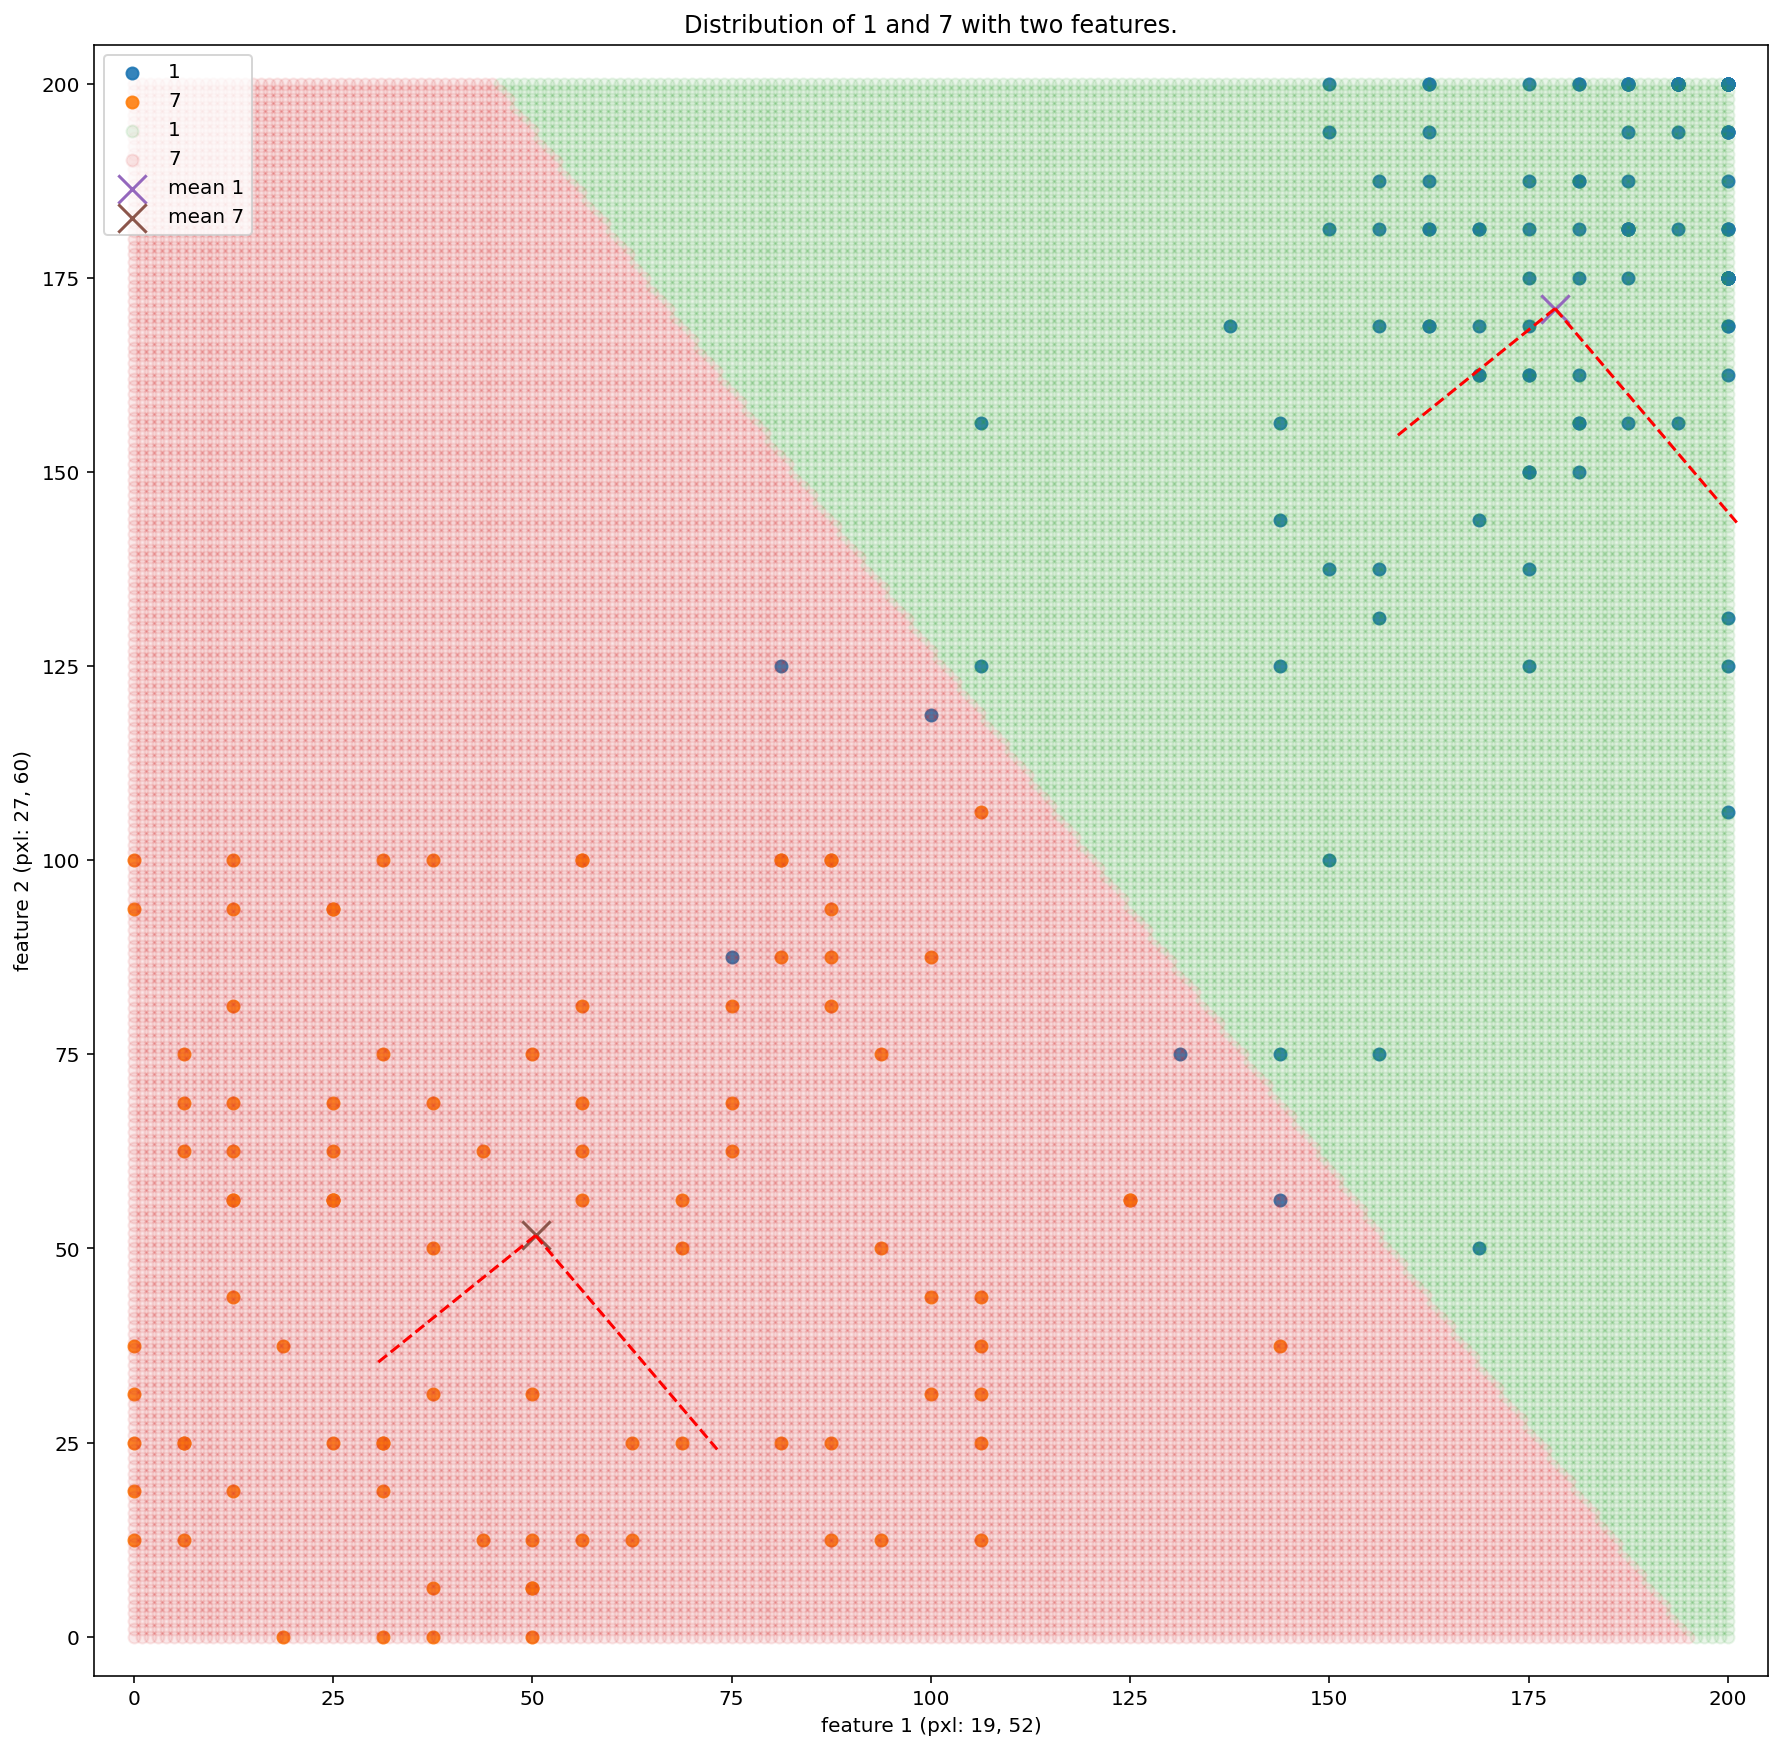

In [18]:
all_pixels_1 = np.array([np.arange(201) for i in range(201)]).flatten() / 200 *16
all_pixels_2 = np.array([np.ones(201) * i for i in range(201)]).flatten() / 200 *16

all_pixels_matrix = np.array([all_pixels_1, all_pixels_2]).T

all_pixels = lda(training_features, Y_train, all_pixels_matrix)
all_pixels_1_class1 = all_pixels_1[all_pixels == 1] * 200 / 16
all_pixels_2_class1 = all_pixels_2[all_pixels == 1] * 200 / 16
all_pixels_1_class7 = all_pixels_1[all_pixels == 7] * 200 / 16
all_pixels_2_class7 = all_pixels_2[all_pixels == 7] * 200 / 16

mu,sigma, p = fit_lda(training_features, Y_train)
w, v = np.linalg.eig(sigma)

plt.plot([class1_mean_1 * 200 / 16,(class1_mean_1 * 200 / 16) + (np.sqrt(w[0])* 200 / 16) * v[0,0] ],[class1_mean_2 * 200 / 16, (class1_mean_2 * 200 / 16) + (np.sqrt(w[0])* 200 / 16) * v[0,1]], "r--")
plt.plot([class1_mean_1 * 200 / 16,(class1_mean_1 * 200 / 16) + (np.sqrt(w[1])* 200 / 16) * v[1,0] ],[class1_mean_2 * 200 / 16, (class1_mean_2 * 200 / 16) + (np.sqrt(w[1])* 200 / 16) * v[1,1]], "r--")
plt.plot([class7_mean_1 * 200 / 16,(class7_mean_1 * 200 / 16) + (np.sqrt(w[0])* 200 / 16) * v[0,0] ],[class7_mean_2 * 200 / 16, (class7_mean_2 * 200 / 16) + (np.sqrt(w[0])* 200 / 16) * v[0,1]], "r--")
plt.plot([class7_mean_1 * 200 / 16,(class7_mean_1 * 200 / 16) + (np.sqrt(w[1])* 200 / 16) * v[1,0] ],[class7_mean_2 * 200 / 16, (class7_mean_2 * 200 / 16) + (np.sqrt(w[1])* 200 / 16) * v[1,1]], "r--")

class1_mean_1,class1_mean_2,class7_mean_1,class7_mean_2 = calculate_means(training_feature_1, training_feature_2, Y_train)

train_feature_1_class_1 = training_feature_1[Y_train == 1]
train_feature_2_class_1 = training_feature_2[Y_train == 1]
train_feature_1_class_7 = training_feature_1[Y_train == 7]
train_feature_2_class_7 = training_feature_2[Y_train == 7]

plt_feature_1_1 = train_feature_1_class_1 * 200 / 16
plt_feature_2_1 = train_feature_2_class_1 * 200 / 16
plt_feature_1_7 = train_feature_1_class_7 * 200 / 16
plt_feature_2_7 = train_feature_2_class_7 * 200 / 16

plt.scatter(plt_feature_1_1,plt_feature_2_1,label="1",alpha=0.9)
plt.scatter(plt_feature_1_7,plt_feature_2_7,label="7",alpha=0.9)
plt.scatter(all_pixels_1_class1,all_pixels_2_class1,label="1",alpha=0.1)
plt.scatter(all_pixels_1_class7,all_pixels_2_class7,label="7",alpha=0.1)
plt.scatter(class1_mean_1 * 200 / 16,class1_mean_2 * 200 / 16,label="mean 1",alpha=1, marker="x", s=200)
plt.scatter(class7_mean_1 * 200 / 16,class7_mean_2 * 200 / 16,label="mean 7",alpha=1, marker="x", s=200)


plt.xlim(-5, 205)
plt.ylim(-5, 205)
plt.xlabel("feature 1 (pxl: 19, 52)")
plt.ylabel("feature 2 (pxl: 27, 60)")
plt.legend(loc='upper left')
plt.rcParams["figure.figsize"] = (15,15)
t = plt.title("Distribution of 1 and 7 with two features.")


### 4.4 Performance evaluation LDA

In [19]:
def cross_validate_lda(data, target, L):

    X_folds, y_folds = split_folds(data, target, L)
    error_rates_own = []

    for n in range(L):
# construct train and test set from folds
        X_train_f = np.concatenate([X_folds[i] for i in range(L) if i != n])
        X_test_f = X_folds[n]
        y_train_f = np.concatenate([y_folds[i] for i in range(L) if i != n])
        y_test_f = y_folds[n]
        
        mu, sigma, p = fit_lda(X_train_f, y_train_f)
        predicted_y = predict_lda(mu, sigma, p, X_test_f)
        error_rates_own.append(error_test(y_test_f, predicted_y))
        
    return np.mean(error_rates_own)

print("test error with 10-fold cross validation:", cross_validate_lda(training_features, Y_train, 10))

test error with 10-fold cross validation: 0.018398268398268396
